# Using Deep Learning for Sentence Score Prediction - LSTMs
## Overview

Sentence-to-sentence LSTMs for text regression

#### Approach
- Split this data set into two sets - one for training our DL model, and one for evaluation  
- Use Keras to create an LSTM with multiple layers. We will train this model on both CPU and GPU environments and compare runtimes  
- Evaluate and test the model on the test set and look at a few individual yelp examples  




In [1]:
import numpy as np
import pandas as pd
import os, re, time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

from multiprocessing import cpu_count
print(cpu_count())

16


In [76]:
%pip install pandarallel
import multiprocessing

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

import pandarallel
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)

  Preparing metadata (setup.py) ... done
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16677 sha256=b2040f7caf72d72066c7c2297d233a7e006f59eb72532f3c0dc283f5e408e8bb
  Stored in directory: /home/jupyter/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel
Note: you may need to restart the kernel to use updated packages.
Available CPUs: 16
INFO: Pandarallel will run on 15 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [58]:
import tensorflow as tf
from tensorflow import keras


from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Convolution1D, Flatten, LeakyReLU
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, GlobalAveragePooling1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Concatenate

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


from keras.models import load_model

from tensorflow.keras.datasets import imdb

from tensorflow.keras.utils import model_to_dot

In [3]:
tf.config.list_physical_devices()

2023-05-20 00:56:24.030674: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-20 00:56:24.030716: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-20 00:56:24.030741: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ml-essay-grading): /proc/driver/nvidia/version does not exist


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [4]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [5]:
df_proc=pd.read_csv('../00_gcp_data/preprocessed-essay.csv')
df_proc.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,cleaned_tokenize_text,corrected_text,...,sent_count,sent_len,mistakes,num_mistakes,word_count,noun_count,verb_count,adjective_count,adverb_count,Score_Category
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,think students would benefit learning home won...,think students would benefit learning home won...,...,18,14.500000,NaN,0,261,61,25,25,5,medium
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,problem change let best matter happening chang...,problem change let best matter happening chang...,...,14,38.071429,NaN,0,533,100,56,37,9,medium
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,dear principal change school policy grade aver...,dear principal change school policy grade aver...,...,19,16.842105,NaN,0,320,58,20,33,5,medium
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,best time life become agree greatest accomplis...,best time life become agree greatest accomplis...,...,36,20.222222,NaN,0,728,106,73,62,22,high
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,small act kindness impact people change people...,small act kindness impact people change people...,...,3,78.000000,kindess homeles triying greate kindess wount t...,11,234,58,21,18,5,medium


In [6]:
pd.options.display.max_colwidth=None
df_proc[['corrected_text','lemmatized_text']].sample(2)

,corrected_text,lemmatized_text
2779,something beyond already mastered never grow past experiences strongly agree life things easily handed want something bad enough work hard wan become better version people around world look certain successful people wish become like money cars fame like famous rapper aba youngboy made known music rapping life difficult obstacles make growing life successful something going happen night takes time patience every task comes difficult obstacle try put make wan give people usually tend give easily way come obstacles move forward get keep trying barack obama one best well liked president worked hard believed helped illegal immigrants around country get opportunity get job legally obama many difficult task passion believed never made wan give kept trying grow help undocumented immigrants voices heard immigrants nowadays tend harder people come around world looking better life well paid jobs safe home family majority immigrants come nothing couple clothes shoes usually stay half immigrants work twice hard get food table clothes kids wife mindset goals passionate something powerful tool many immigrants work hard enough eventually become citizen lot obstacles complete immigrants learn english language difficult studying working hard long hours master tend grow american society shows anyone really put head accomplish anything,something beyond already master never grow past experience strongly agree life thing easily hand want something bad enough work hard wan become well version people around world look certain successful people wish become like money car fame like famous rapper aba youngboy make know music rap life difficult obstacle make grow life successful something go happen night take time patience every task come difficult obstacle try put make wan give people usually tend give easily way come obstacle move forward get keep try barack obama one best well like president work hard believe help illegal immigrant around country get opportunity get job legally obama many difficult task passion believe never make wan give kept try grow help undocumented immigrant voice heard immigrant nowadays tend harder people come around world look well life well paid job safe home family majority immigrant come nothing couple clothes shoe usually stay half immigrant work twice hard get food table clothes kid wife mindset goal passionate something powerful tool many immigrant work hard enough eventually become citizen lot obstacle complete immigrant learn english language difficult study work hard long hour master tend grow american society show anyone really put head accomplish anything
3869,occupations internships shadowing opportunities companies heard school company offer students visit learn work interest student want one want know special different others student school tell choose instead another student daughter single mother five children possible one college child oldest siblings also second mon work take care instead college that mon think give opportunity learn company mon change mind put college know college certificate better stay home taking care siblings work minimum salary certificated better salary able help even home good job put siblings college another reason one best students school never problems school anyone either teacher student never anything hurt company learning something help future job maybe working finish college never feel like waste time never happened secure able know hard choose couple students many schools investment effort dedication really appreciate good job visit choose given opportunity learn company given opportunity believe success someone competitive world,occupation internship shadow opportunity company heard school company offer student visit learn work interest student want one want know special different others student school tell choose instead another student daughter single mother five child possible one college child old sibling also second mon work take care

### Setting variables

In [7]:
## Setting text and target variables

textVar=df_proc['lemmatized_text']
targetVar=df_proc[["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]]

### Parameters - for LSTM

In [84]:
# make our experiments repeatable
np.random.seed(0)

# Model Hyperparameters
embedding_dim = 100

# Here we specify the number of units of our hidden layer
lstm_dims = 196

# Training parameters. Here we specify the training of the net will use 64 examples for each backprop iteration
batch_size = 64

# We will go thru the entire data set 80 times
num_epochs = 10

# Prepossessing parameters
# We will input the first 1000 words of every essay (and pad out with nulls if a essay review is <1000 words
# We will also build our model using the most frequent 6000 words in our yelp 'dictionary'

sequence_length = 1000
max_features = 7000

#Specify the number of variables to predic
num_classes = 6
#num_classes = target.nunique()

### Tokenize the data and pad sequences

In [46]:
X = textVar.values
Y = targetVar

train_samples, test_samples, train_targets, test_targets = train_test_split(X,Y, test_size = 0.20, random_state = 1010)

In [47]:
# Check how many columns we have, make sure we have our sequence length set correctly

print(train_samples.shape,train_targets.shape)
print(test_samples.shape,test_targets.shape)

(3128,) (3128, 6)
(783,) (783, 6)


In [48]:
vectorizer = TextVectorization(max_tokens=max_features, output_sequence_length=sequence_length, ngrams=None, pad_to_max_tokens=True)

text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(128)
vectorizer.adapt(text_ds)

In [49]:
vectorizer.get_vocabulary()[:20]

['',
 '[UNK]',
 'student',
 'people',
 'school',
 'work',
 'get',
 'make',
 'time',
 'want',
 'good',
 'help',
 'like',
 'life',
 'thing',
 'would',
 'think',
 'class',
 'one',
 'well']

In [65]:
vectorizer

### Convert our list of strings data to Numpy arrays of integer indices

In [50]:
X_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
X_test = vectorizer(np.array([[s] for s in test_samples])).numpy()

Y_train = np.array(train_targets)
Y_test = np.array(test_targets)

In [51]:
X_train[:3]

array([[667,  81,  21, ...,   0,   0,   0],
       [ 16, 272,  10, ...,   0,   0,   0],
       [ 19, 285,   9, ...,   0,   0,   0]])

In [52]:
Y_train

array([[2.5, 2.5, 2.5, 2. , 2.5, 2. ],
       [2.5, 2. , 2. , 2.5, 2.5, 2.5],
       [3.5, 2.5, 3. , 3.5, 2.5, 2.5],
       ...,
       [3. , 3.5, 3.5, 3. , 3. , 3.5],
       [2.5, 2.5, 2.5, 2.5, 2.5, 3. ],
       [3. , 2.5, 3. , 2.5, 2.5, 2.5]])

### Load a pretrained vector space model - GLOVE

In [53]:
embeddings_index = {}

glove_dir = '../00_gcp_data/'
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [62]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

num_tokens = len(voc) + 2
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 6638 words (362 misses)


In [66]:
word_index

{'': 0,
 '[UNK]': 1,
 'student': 2,
 'people': 3,
 'school': 4,
 'work': 5,
 'get': 6,
 'make': 7,
 'time': 8,
 'want': 9,
 'good': 10,
 'help': 11,
 'like': 12,
 'life': 13,
 'thing': 14,
 'would': 15,
 'think': 16,
 'class': 17,
 'one': 18,
 'well': 19,
 'know': 20,
 'take': 21,
 'learn': 22,
 'need': 23,
 'go': 24,
 'also': 25,
 'something': 26,
 'person': 27,
 'example': 28,
 'way': 29,
 'say': 30,
 'try': 31,
 'day': 32,
 'always': 33,
 'give': 34,
 'many': 35,
 'lot': 36,
 'use': 37,
 'change': 38,
 'reason': 39,
 'friend': 40,
 'teacher': 41,
 'first': 42,
 'home': 43,
 'could': 44,
 'do': 45,
 'job': 46,
 'bad': 47,
 'high': 48,
 'year': 49,
 'idea': 50,
 'see': 51,
 'really': 52,
 'positive': 53,
 'hard': 54,
 'feel': 55,
 'attitude': 56,
 'new': 57,
 'others': 58,
 'technology': 59,
 'important': 60,
 'even': 61,
 'career': 62,
 'family': 63,
 'never': 64,
 'someone': 65,
 'come': 66,
 'different': 67,
 'best': 68,
 'success': 69,
 'play': 70,
 'start': 71,
 'world': 72,
 'fu

In [63]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.79618001,  0.56779999, -0.96452999, ..., -0.28637001,
         0.54822999, -0.33597001],
       ...,
       [-0.01211   ,  0.001921  , -0.26157999, ...,  0.039627  ,
        -0.12142   , -0.44775   ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

## Load the pre-trained word embeddings matrix into an Embedding layer
We will keep embeddings static with **trainable=False**

In [68]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

## Baseline LSTM Model

In [73]:
sequence_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(sequence_input)

x = LSTM(lstm_dims, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(6, activation="linear")(x)


model_lstm_1 = Model(sequence_input, preds)
model_lstm_1.compile(loss = 'mean_squared_error', optimizer='adam', metrics = ['mean_squared_error'])

model_lstm_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 100)         700200    
                                                                 
 lstm_layer (LSTM)           (None, None, 196)         232848    
                                                                 
 global_max_pooling1d_2 (Glo  (None, 196)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_4 (Dropout)         (None, 196)               0         
                                                                 
 dense_4 (Dense)             (None, 50)                9850      
                                                           

In [71]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [72]:
SVG(model_to_dot(model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

InvocationException: GraphViz's executables not found

## Training the model

In [89]:
filepath="/home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best"
checkpoint = ModelCheckpoint(filepath, monitor='val_mean_squared_error',
                             verbose=1, save_best_only=True, save_weights_only=False, overwrite=True, mode='min')

#only save model if it reduces MSE

callbacks_list = [checkpoint]

t1 = time.time()
model_lstm_1_history = model_lstm_1.fit(X_train, Y_train,
                    batch_size=batch_size, 
                    epochs=num_epochs,
                    validation_split=0.2,
                    callbacks = callbacks_list,
                    verbose=1)
t2 = time.time()
print("LSTM Glove model train time = %d seconds" %(t2-t1))

Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 0.3609 - mean_squared_error: 0.3609
Epoch 1: val_mean_squared_error improved from inf to 0.34680, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best/assets


40/40 [==============================] - 70s 2s/step - loss: 0.3609 - mean_squared_error: 0.3609 - val_loss: 0.3468 - val_mean_squared_error: 0.3468
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 0.3562 - mean_squared_error: 0.3562
Epoch 2: val_mean_squared_error improved from 0.34680 to 0.33910, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best/assets


40/40 [==============================] - 74s 2s/step - loss: 0.3562 - mean_squared_error: 0.3562 - val_loss: 0.3391 - val_mean_squared_error: 0.3391
Epoch 3/10
40/40 [==============================] - ETA: 0s - loss: 0.3486 - mean_squared_error: 0.3486
Epoch 3: val_mean_squared_error improved from 0.33910 to 0.33868, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best/assets


40/40 [==============================] - 89s 2s/step - loss: 0.3486 - mean_squared_error: 0.3486 - val_loss: 0.3387 - val_mean_squared_error: 0.3387
Epoch 4/10
40/40 [==============================] - ETA: 0s - loss: 0.3368 - mean_squared_error: 0.3368
Epoch 4: val_mean_squared_error did not improve from 0.33868
40/40 [==============================] - 79s 2s/step - loss: 0.3368 - mean_squared_error: 0.3368 - val_loss: 0.3422 - val_mean_squared_error: 0.3422
Epoch 5/10
40/40 [==============================] - ETA: 0s - loss: 0.3570 - mean_squared_error: 0.3570
Epoch 5: val_mean_squared_error improved from 0.33868 to 0.33245, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best/assets


40/40 [==============================] - 86s 2s/step - loss: 0.3570 - mean_squared_error: 0.3570 - val_loss: 0.3324 - val_mean_squared_error: 0.3324
Epoch 6/10
40/40 [==============================] - ETA: 0s - loss: 0.3524 - mean_squared_error: 0.3524
Epoch 6: val_mean_squared_error improved from 0.33245 to 0.33131, saving model to /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best/assets


INFO:tensorflow:Assets written to: /home/jupyter/automatic-essay-grading-DL/05_Model_files'/lstm_glove_weights_best/assets


40/40 [==============================] - 86s 2s/step - loss: 0.3524 - mean_squared_error: 0.3524 - val_loss: 0.3313 - val_mean_squared_error: 0.3313
Epoch 7/10
40/40 [==============================] - ETA: 0s - loss: 0.3222 - mean_squared_error: 0.3222
Epoch 7: val_mean_squared_error did not improve from 0.33131
40/40 [==============================] - 79s 2s/step - loss: 0.3222 - mean_squared_error: 0.3222 - val_loss: 0.3381 - val_mean_squared_error: 0.3381
Epoch 8/10
40/40 [==============================] - ETA: 0s - loss: 0.3249 - mean_squared_error: 0.3249
Epoch 8: val_mean_squared_error did not improve from 0.33131
40/40 [==============================] - 79s 2s/step - loss: 0.3249 - mean_squared_error: 0.3249 - val_loss: 0.3459 - val_mean_squared_error: 0.3459
Epoch 9/10
40/40 [==============================] - ETA: 0s - loss: 0.3223 - mean_squared_error: 0.3223
Epoch 9: val_mean_squared_error did not improve from 0.33131
40/40 [==============================] - 78s 2s/step - los

In [81]:
model_lstm_1_history.history.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

In [85]:
def plot_train(history):
    """
    Plot the keras epoch results thru training
    """
    h = history.history
    #loss_values = history_dict['loss']
    #val_loss_values = history_dict['val_loss']
    #acc = history_dict['acc']
    #val_acc = history_dict['val_accuracy']
    
    #plt.plot(epochs, loss_values, 'bo', label='Training loss')
    #plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    
    epochs = range(1, len(h['mean_squared_error']) + 1)
    plt.plot(epochs, h['mean_squared_error'], 'go', label='Training MSE')
    plt.plot(epochs, h['val_mean_squared_error'], 'g', label='Validation MSE')
    plt.title('Training and Validation MSE')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

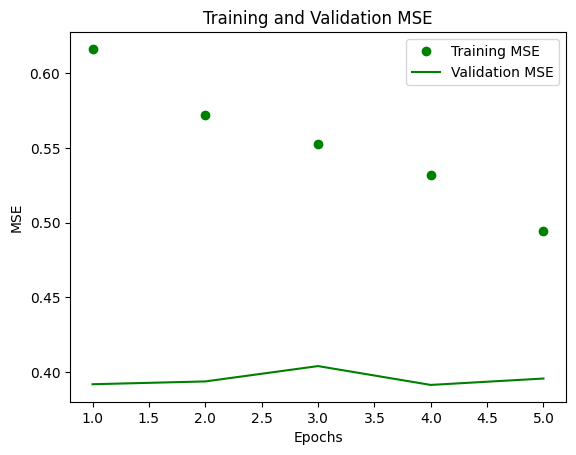

In [83]:
plot_train(model_lstm_1_history)

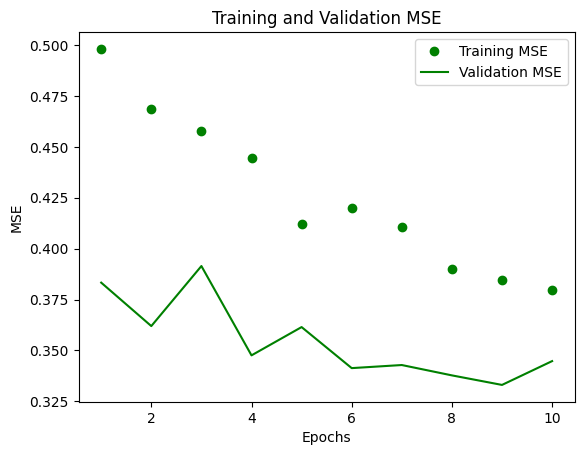

In [87]:
plot_train(model_lstm_1_history)

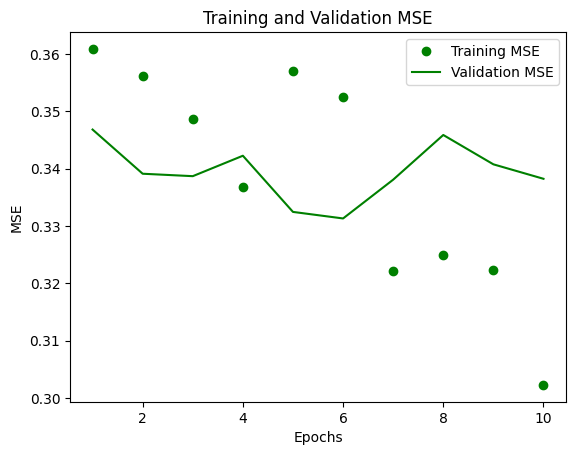

In [90]:
plot_train(model_lstm_1_history)

In [142]:
model_lstm_1_history.model.get_config()

{'name': 'sequential_4',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 1000),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'embedding_3_input'}},
  {'class_name': 'Embedding',
   'config': {'name': 'embedding_3',
    'trainable': False,
    'dtype': 'float32',
    'batch_input_shape': (None, 1000),
    'input_dim': 10283,
    'output_dim': 100,
    'embeddings_initializer': {'class_name': 'RandomUniform',
     'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
    'embeddings_regularizer': None,
    'activity_regularizer': None,
    'embeddings_constraint': None,
    'mask_zero': False,
    'input_length': 1000}},
  {'class_name': 'Conv1D',
   'config': {'name': 'conv1d_9',
    'trainable': True,
    'dtype': 'float32',
    'filters': 10,
    'kernel_size': (3,),
    'strides': (1,),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1,),
    'groups': 1,
    'activation': 'rel

In [91]:
model_lstm_1.evaluate(X_test, Y_test)

25/25 [==============================] - 14s 562ms/step - loss: 0.3466 - mean_squared_error: 0.3466


[0.34658941626548767, 0.34658941626548767]

----
## Now trying for 6 different outputs